In [1]:
import pickle

import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm

# Load the latencies from the file
with open('video_latency.pkl', 'rb') as file:
    latencies_video = pickle.load(file)

print(latencies_video.shape)
import pandas as pd




(2048, 2044)


In [2]:
import numpy as np
#latencies_video = np.nan_to_num(latencies_video, nan=-1)
latencies_video_01ms = latencies_video*10

In [3]:
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm

def max_pool_2d(A, kernel_size):
    # Pad the array if it's not divisible by kernel_size
    m, n = A.shape
    pad_m = (kernel_size - m % kernel_size) % kernel_size
    pad_n = (kernel_size - n % kernel_size) % kernel_size
    A_padded = np.pad(A, ((0, pad_m), (0, pad_n)), mode='constant', constant_values=np.nan)
    
    # Reshape and find max
    m_pooled, n_pooled = A_padded.shape
    A_reshaped = A_padded.reshape(m_pooled // kernel_size, kernel_size, n_pooled // kernel_size, kernel_size)
    
    # If any value in the pool is NaN, the result is NaN
    has_nan = np.isnan(A_reshaped).any(axis=(1, 3))
    
    # Compute max ignoring NaNs
    max_values = np.nanmax(A_reshaped, axis=(1, 3))
    
    # Set pools with NaNs to NaN
    max_values[has_nan] = np.nan
    
    return max_values

def polynomial_func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*x*y + f*y**2

D:\temp\ipykernel_33996\201093690.py:20: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(A_reshaped, axis=(1, 3))
Calculating CV: 100%|██████████| 167690/167690 [02:31<00:00, 1106.77it/s] 


Mean conduction velocity: 10.660374530259991 cm/s


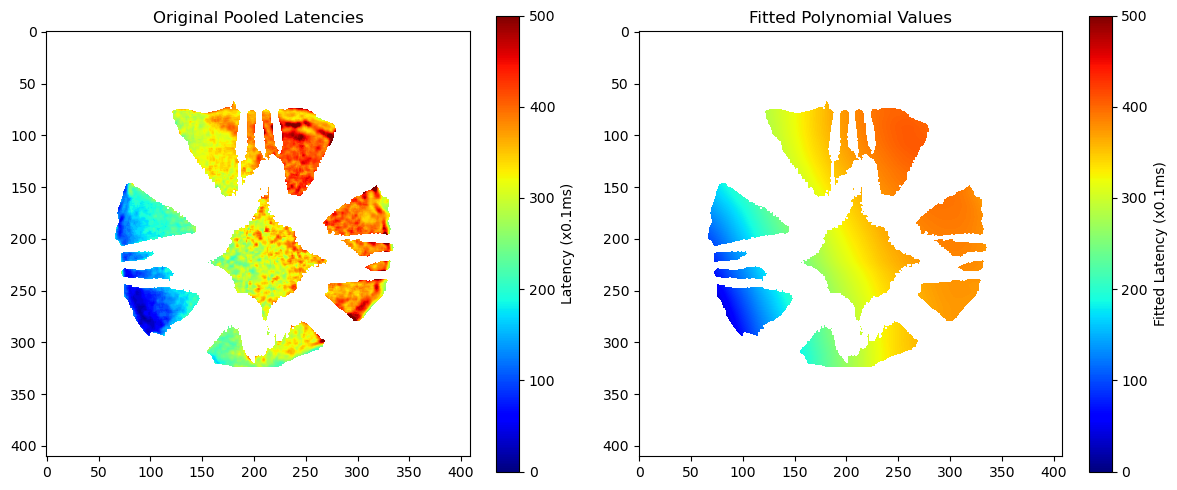

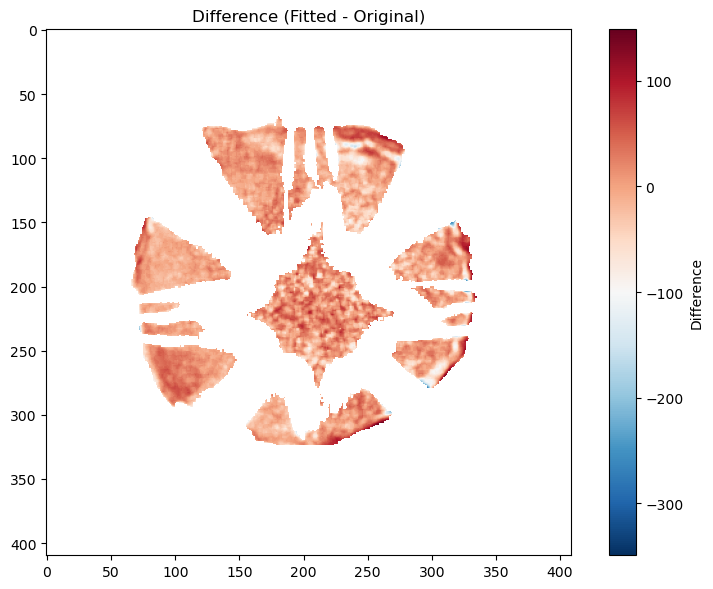

In [4]:
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib.pyplot as plt

# ... (keep the previous functions as they are) ...

def calculate_cv(latencies_video, spatial_resolution_mm=1, time_resolution_ms=1, window_size_mm=4, pool_size=10):
    # Perform max pooling
    latencies_pooled = max_pool_2d(latencies_video, pool_size)
    
    # Update spatial resolution
    spatial_resolution_mm *= pool_size
    
    rows, cols = latencies_pooled.shape
    cv_x = np.zeros_like(latencies_pooled)
    cv_y = np.zeros_like(latencies_pooled)
    
    # Create arrays to store fitted values for visualization
    fitted_values = np.full_like(latencies_pooled, np.nan)
    
    # Convert window size from mm to pixels
    window_size_px = max(1, int(window_size_mm / spatial_resolution_mm))
    
    # Create progress bar
    total_pixels = rows * cols
    pbar = tqdm(total=total_pixels, desc="Calculating CV")

    for i in range(rows):
        for j in range(cols):
            if np.isnan(latencies_pooled[i, j]):
                pbar.update(1)
                continue
            
            # Define the local window
            x_min, x_max = max(0, i-window_size_px), min(rows, i+window_size_px+1)
            y_min, y_max = max(0, j-window_size_px), min(cols, j+window_size_px+1)
            
            # Get local coordinates and latencies
            y_local, x_local = np.meshgrid(np.arange(y_min-j, y_max-j), 
                                           np.arange(x_min-i, x_max-i))
            t_local = latencies_pooled[x_min:x_max, y_min:y_max]
            
            # Ensure all arrays have the same shape
            x_local = x_local.flatten()
            y_local = y_local.flatten()
            t_local = t_local.flatten()
            
            # Remove NaN values
            mask = ~np.isnan(t_local)
            x_local, y_local, t_local = x_local[mask], y_local[mask], t_local[mask]
            
            if len(t_local) < 6:  # Need at least 6 points for the fit
                pbar.update(1)
                continue
            
            # Prepare arrays for curve fitting
            xy_local = np.vstack((x_local, y_local))
            
            # Fit the polynomial
            try:
                popt, _ = curve_fit(polynomial_func, xy_local, t_local)
            except:
                pbar.update(1)
                continue
            
            # Calculate partial derivatives
            dT_dx = popt[1] + 2*popt[3]*0 + popt[4]*0  # at x,y = 0,0
            dT_dy = popt[2] + popt[4]*0 + 2*popt[5]*0  # at x,y = 0,0
            
            # Calculate velocity components
            denominator_x = dT_dx + dT_dx * dT_dy**2
            denominator_y = dT_dy + dT_dy * dT_dx**2
            
            if denominator_x != 0:
                cv_x[i, j] = (1 + dT_dy**2) / denominator_x
            if denominator_y != 0:
                cv_y[i, j] = (1 + dT_dx**2) / denominator_y
            
            # Store fitted value for visualization
            fitted_values[i, j] = polynomial_func([0, 0], *popt)
            
            pbar.update(1)
    
    pbar.close()
    
    # Convert to actual velocities (mm/ms)
    cv_x *= spatial_resolution_mm / time_resolution_ms
    cv_y *= spatial_resolution_mm / time_resolution_ms
    
    # Calculate speed
    cv_magnitude = np.sqrt(cv_x**2 + cv_y**2)
    
    return cv_x, cv_y, cv_magnitude, fitted_values, latencies_pooled

# Usage
pool_size = 5             # 10x10 pooling
spatial_resolution_mm = 0.8249  # 1 um per pixel
time_resolution_ms = 1     # 1 0.1 ms per time unit
window_size_mm = 600        # um window, as suggested in the paper

cv_x, cv_y, cv_magnitude, fitted_values, latencies_pooled = calculate_cv(latencies_video_01ms, 
                                        spatial_resolution_mm=spatial_resolution_mm,
                                        time_resolution_ms=time_resolution_ms,
                                        window_size_mm=window_size_mm,
                                        pool_size=pool_size)

# Print mean conduction velocity
print(f"Mean conduction velocity: {np.nanmean(cv_magnitude)} cm/s")

# Visualize the fitted polynomial
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.title("Original Pooled Latencies")
im1 = plt.imshow(latencies_pooled, cmap='jet', vmin=0, vmax=500)
plt.colorbar(im1, label='Latency (x0.1ms)')

plt.subplot(122)
plt.title("Fitted Polynomial Values")
im2 = plt.imshow(fitted_values, cmap='jet', vmin=0, vmax=500)
plt.colorbar(im2, label='Fitted Latency (x0.1ms)')

plt.tight_layout()
plt.show()

# Visualize the difference
plt.figure(figsize=(8, 6))
plt.title("Difference (Fitted - Original)")
difference = fitted_values - latencies_pooled
im3 = plt.imshow(difference, cmap='RdBu_r')
plt.colorbar(im3, label='Difference')
plt.tight_layout()
plt.show()

In [5]:
plt.imshow(latencies_pooled, cmap='jet', vmin=0, vmax=600)
plt.axis('off')  # Remove axis labels and ticks

# Save the figure with high resolution and no padding
output_path = 'CalciumRaw0-60msSameWithFigure.png'
plt.savefig(output_path, dpi=600, bbox_inches='tight', pad_inches=0, transparent=True)
plt.close()


In [6]:
print(np.nanmax(latencies_pooled))
print(np.nanmin(latencies_pooled))
print(np.nanmax(fitted_values))
print(np.nanmin(fitted_values))

710.0000000000001
10.000000000000009
408.06837091305385
38.21747036294961


D:\temp\ipykernel_33996\201093690.py:20: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(A_reshaped, axis=(1, 3))
Fitting Polynomial: 100%|██████████| 54852/54852 [05:05<00:00, 179.83it/s]


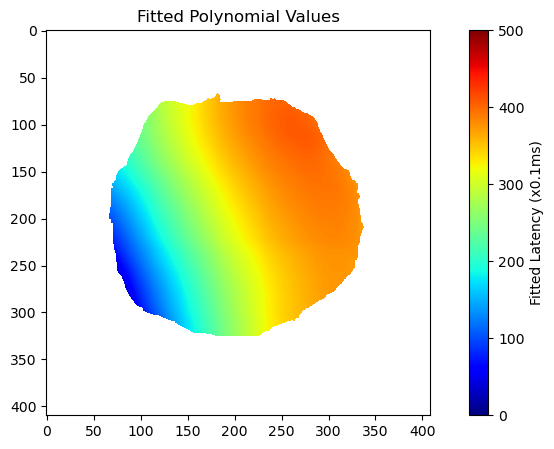

In [7]:
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
def calculate_fitted_values(latencies_video, mask_path, spatial_resolution_mm=1, window_size_mm=4, pool_size=10):
    # Perform max pooling to reduce resolution
    latencies_pooled = max_pool_2d(latencies_video, pool_size)
    
    # Update spatial resolution
    spatial_resolution_mm *= pool_size
    
    rows, cols = latencies_pooled.shape
    fitted_values = np.full_like(latencies_pooled, np.nan)

    # Convert window size from mm to pixels
    window_size_px = max(1, int(window_size_mm / spatial_resolution_mm))

    # Load custom mask (MaskWholeCalcium)
    final_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if final_mask is None:
        raise ValueError("Invalid mask size or file not found.")

    # Resize the mask to match the pooled latency dimensions
    final_mask_resized = cv2.resize(final_mask, (cols, rows), interpolation=cv2.INTER_NEAREST)

    # Create a new valid region based on the resized mask
    mask_valid = final_mask_resized > 0  # Areas with 255 are valid

    # Do not modify latencies_pooled based on NaNs; instead, rely solely on the new mask
    valid_pixels = mask_valid.flatten()

    # Create progress bar
    total_pixels = np.count_nonzero(mask_valid)
    pbar = tqdm(total=total_pixels, desc="Fitting Polynomial")

    for i in range(rows):
        for j in range(cols):
            if not mask_valid[i, j]:  # Skip if outside the mask
                continue

            # Define the local window
            x_min, x_max = max(0, i - window_size_px), min(rows, i + window_size_px + 1)
            y_min, y_max = max(0, j - window_size_px), min(cols, j + window_size_px + 1)

            # Get local coordinates and latencies
            y_local, x_local = np.meshgrid(np.arange(y_min - j, y_max - j), 
                                           np.arange(x_min - i, x_max - i))
            t_local = latencies_pooled[x_min:x_max, y_min:y_max]

            # Flatten arrays
            x_local = x_local.flatten()
            y_local = y_local.flatten()
            t_local = t_local.flatten()

            # Remove NaN values from local window
            mask = ~np.isnan(t_local)
            x_local, y_local, t_local = x_local[mask], y_local[mask], t_local[mask]

            if len(t_local) < 6:  # Need at least 6 points for curve fitting
                continue

            # Prepare data for curve fitting
            xy_local = np.vstack((x_local, y_local))

            # Fit the polynomial
            try:
                popt, _ = curve_fit(polynomial_func, xy_local, t_local)
                # Store the fitted value at the current pixel position
                fitted_values[i, j] = polynomial_func([0, 0], *popt)
            except:
                continue

            pbar.update(1)

    pbar.close()
    
    return fitted_values, latencies_pooled
mask_path = 'MaskWholeCalcium.png'
spatial_resolution_mm = 0.8249  
window_size_mm = 600  
pool_size = 5  

fitted_values, latencies_pooled = calculate_fitted_values(
    latencies_video_01ms, 
    mask_path,
    spatial_resolution_mm=spatial_resolution_mm,
    window_size_mm=window_size_mm,
    pool_size=pool_size
)

# Display the fitted polynomial values
plt.figure(figsize=(10, 5))
plt.title("Fitted Polynomial Values")
plt.imshow(fitted_values, cmap='jet', vmin=0, vmax=500)
plt.colorbar(label='Fitted Latency (x0.1ms)')
plt.show()


In [8]:
import matplotlib.pyplot as plt
height, width = fitted_values.shape

# Create a meshgrid for contour plotting
x = np.arange(width)
y = np.arange(height)
X, Y = np.meshgrid(x, y)
Y = np.flipud(Y)  # Flip the Y-axis as requested

# Create the plot without axis, labels, and colorbar
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')  # Equal aspect ratio

# Plot contour with jet colormap
contour = ax.contourf(X, Y, fitted_values/10, levels=np.linspace(0, 50, num=11), cmap='jet')
contour_lines = ax.contour(X, Y, fitted_values/10, levels=np.linspace(0, 50, num=11), colors='black', linewidths=1)
#ax.clabel(contour_lines, inline=True, fontsize=8)  # Add contour labels with font size 8

# Remove axis, ticks, and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Save the figure with high resolution (1200 dpi)
output_path = 'CalciumWholeContour_0_50ms.png'
plt.savefig(output_path, dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

# Close the plot to free memory
plt.close(fig)

print(f"Contour plot saved as '{output_path}' at 1200 DPI without axis and labels.")
sss

Contour plot saved as 'CalciumWholeContour_0_50ms.png' at 1200 DPI without axis and labels.


NameError: name 'sss' is not defined

KeyboardInterrupt: 

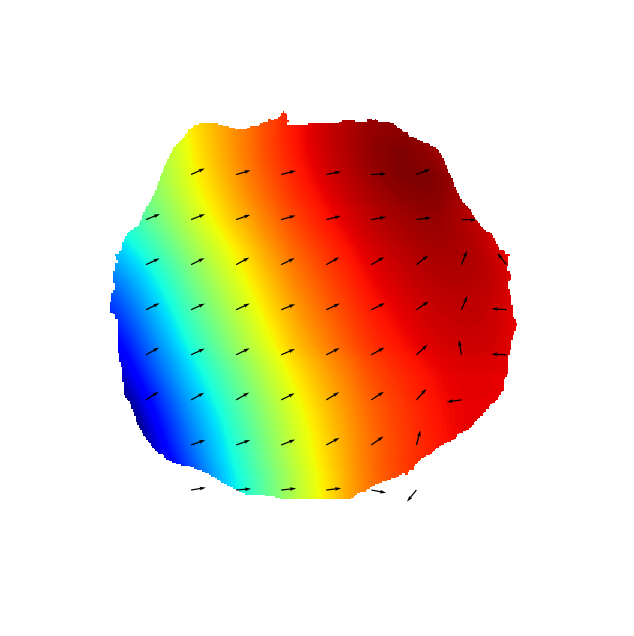

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Downsampling factor
downsample_factor = 30  # Adjust this to control arrow density

# Compute the gradients in X and Y directions
gradient_y, gradient_x = np.gradient(fitted_values)

# Downsample the data
X_downsampled = X[::downsample_factor, ::downsample_factor]
Y_downsampled = Y[::downsample_factor, ::downsample_factor]
grad_x_downsampled = gradient_x[::downsample_factor, ::downsample_factor]
grad_y_downsampled = gradient_y[::downsample_factor, ::downsample_factor]

# Create a mask to plot arrows only where adjacent sampled pixels have values
valid_mask = (
    ~np.isnan(fitted_values[::downsample_factor, ::downsample_factor]) &
    ~np.isnan(fitted_values[::downsample_factor, 1::downsample_factor]) &
    ~np.isnan(fitted_values[1::downsample_factor, ::downsample_factor]) &
    ~np.isnan(fitted_values[1::downsample_factor, 1::downsample_factor])
)

# Filter valid arrow locations
X_valid = X_downsampled[valid_mask]
Y_valid = Y_downsampled[valid_mask]
grad_x_valid = grad_x_downsampled[valid_mask]
grad_y_valid = grad_y_downsampled[valid_mask]

# Create the plot without contour, axis, labels, and colorbar
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')  # Equal aspect ratio

# Plot the arrows on top of a grayscale background
ax.imshow(fitted_values, cmap='jet', origin='upper')  # Show the grayscale background


# Compute the magnitude of the gradient vectors
magnitude = np.sqrt(grad_x_valid**2 + grad_y_valid**2)

# Avoid division by zero by adding a small epsilon
epsilon = 1e-10
grad_x_unit = grad_x_valid / (magnitude + epsilon)
grad_y_unit = grad_y_valid / (magnitude + epsilon)

# Plot the quiver with normalized vectors
ax.quiver(
    X_valid, Y_valid, grad_x_unit, grad_y_unit,  # Normalized vectors
    color='black', angles='xy', scale_units='xy', scale=0.1, width=0.002
)



# ax.quiver(
#     X_valid, Y_valid, grad_x_valid, grad_y_valid,  # Negate Y for correct orientation
#     color='black', angles='xy', scale_units='xy', scale=0.1, width=0.002
# )

# Remove axis, ticks, and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Save the figure with high resolution (1200 dpi)
output_path = 'ArrowPlot.png'
plt.savefig(output_path, dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

# Close the plot to free memory
plt.close(fig)

print(f"Arrow plot saved as '{output_path}' at 1200 DPI without axis and labels.")


In [ ]:
s'sss

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Save the first matrix (latencies_pooled)
plt.figure(figsize=(6, 6))
plt.imshow(latencies_pooled, cmap='jet', vmin=10, vmax=410)
plt.axis('off')  # Remove axis
plt.savefig('latencies_pooled_matrix.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

# Save the second matrix (fitted_values)
plt.figure(figsize=(6, 6))
plt.imshow(fitted_values, cmap='jet', vmin=38.21, vmax=438.21)
plt.axis('off')  # Remove axis
plt.savefig('fitted_values_matrix.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

print("Matrices saved successfully.")


Matrices saved successfully.


In [9]:
sds

NameError: name 'sds' is not defined

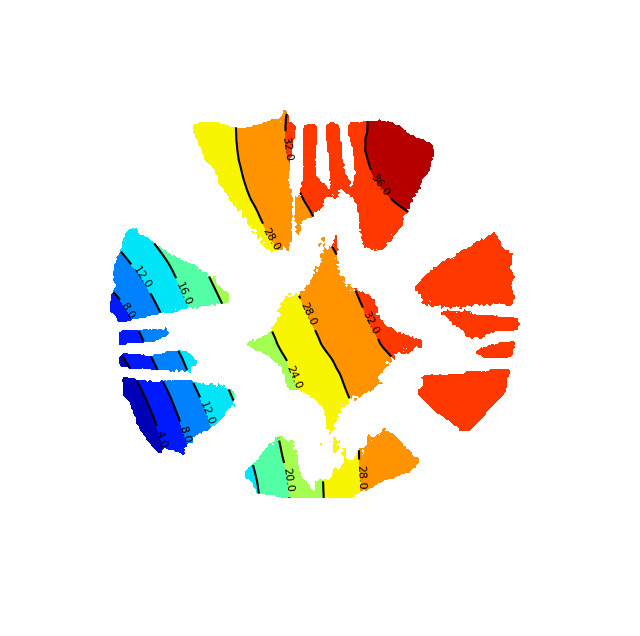

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

# Assuming fitted_values is defined somewhere in your code
fitted_values_to_zero = (fitted_values - 38.21) / 10

# Mask NaN values for contour plotting
masked_values = ma.masked_invalid(fitted_values_to_zero)

# Create grid for plotting
x = np.arange(fitted_values_to_zero.shape[1])
y = np.arange(fitted_values_to_zero.shape[0])
X, Y = np.meshgrid(x, y)
Y = np.flipud(Y)

# Create figure without axis
fig, ax = plt.subplots(figsize=(8, 8))

# Remove axis, ticks, and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Plot contour
contour = ax.contour(X, Y, masked_values, levels=8, colors='black')
plt.contourf(X, Y, masked_values, levels=np.linspace(0, 40, num=11), cmap='jet')  # Filled contour

# Add contour labels (this will keep the numbers)
#plt.clabel(contour, inline=True, fontsize=8, fmt="%.1f")

# Save figure without title, axis, and colorbar at 1200 dpi
plt.savefig("contour_plot.png", dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

# Show plot (optional)
plt.show()


In [9]:
import pickle

# Assume cv_x, cv_y, cv_magnitude, fitted_values, and latencies_pooled are your calculated results

# Create a dictionary to store all the results
results = {
    'cv_x': cv_x,
    'cv_y': cv_y,
    'cv_magnitude': cv_magnitude,
    'fitted_values': fitted_values,
    'latencies_pooled': latencies_pooled,
    'spatial_resolution_mm': spatial_resolution_mm,
    'time_resolution_ms': time_resolution_ms,
    'window_size_mm': window_size_mm,
    'pool_size': pool_size
}

# Save the results to a pickle file
with open('cv_results.pickle', 'wb') as f:
    pickle.dump(results, f)

print("Results saved to cv_results.pickle")

# To load the results later, you can use:
# with open('cv_results.pickle', 'rb') as f:
#     loaded_results = pickle.load(f)

Results saved to cv_results.pickle


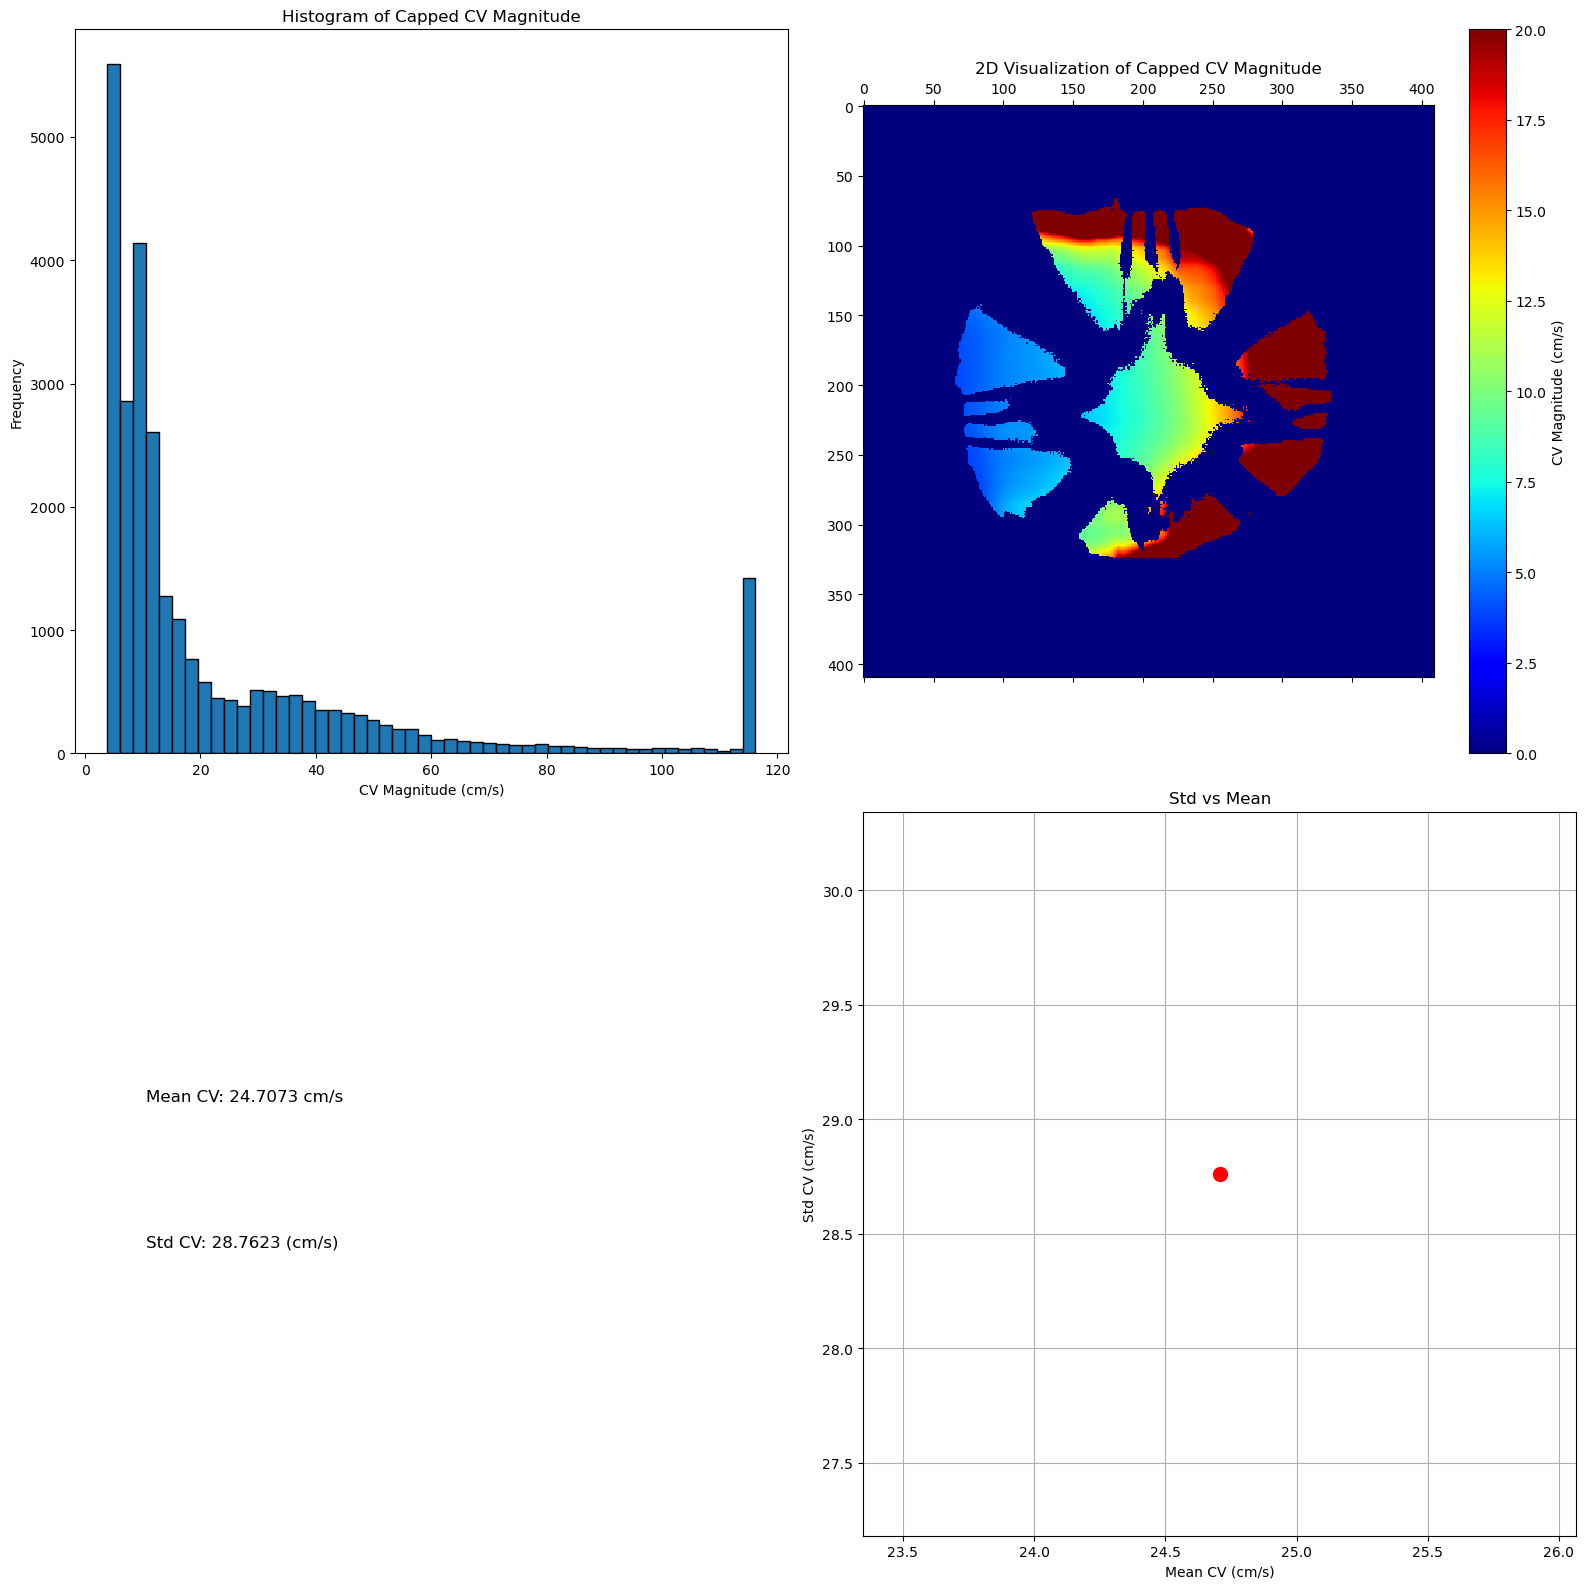

Mean CV: 24.7073 (cm/s)
Variance CV: 28.7623 (cm/s)


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Function to cap values at a specified percentile
def cap_at_percentile(data, percentile):
    cap_value = np.nanpercentile(data[data != 0], percentile)
    return np.clip(data, 0, cap_value)



# Cap CV magnitude at 99th percentile
cv_magnitude_capped = cap_at_percentile(cv_magnitude, 95)

# Create a mask for non-zero values
non_zero_mask = cv_magnitude_capped != 0

# Calculate statistics
mean_cv = np.mean(cv_magnitude_capped[non_zero_mask])
variance_cv = np.std(cv_magnitude_capped[non_zero_mask])

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# Histogram
axs[0, 0].hist(cv_magnitude_capped[non_zero_mask].flatten(), bins=50, edgecolor='black')
axs[0, 0].set_title('Histogram of Capped CV Magnitude')
axs[0, 0].set_xlabel('CV Magnitude (cm/s)')
axs[0, 0].set_ylabel('Frequency')

# Matshow with range from 0 to 20
im = axs[0, 1].matshow(cv_magnitude_capped, cmap='jet', vmin=0, vmax=20)
axs[0, 1].set_title('2D Visualization of Capped CV Magnitude')
plt.colorbar(im, ax=axs[0, 1], label='CV Magnitude (cm/s)')

# Text info
axs[1, 0].axis('off')
axs[1, 0].text(0.1, 0.6, f'Mean CV: {mean_cv:.4f} cm/s', fontsize=12)
axs[1, 0].text(0.1, 0.4, f'Std CV: {variance_cv:.4f} (cm/s)', fontsize=12)

# Scatter plot of Variance vs Mean
axs[1, 1].scatter(mean_cv, variance_cv, color='red', s=100)
axs[1, 1].set_title('Std vs Mean')
axs[1, 1].set_xlabel('Mean CV (cm/s)')
axs[1, 1].set_ylabel('Std CV (cm/s)')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print the results
print(f"Mean CV: {mean_cv:.4f} (cm/s)")
print(f"Variance CV: {variance_cv:.4f} (cm/s)")

D:\temp\ipykernel_34660\3576917893.py:17: RuntimeWarning: invalid value encountered in divide
  cv_x_norm = np.where(magnitude != 0, cv_x_down / magnitude, 0)
D:\temp\ipykernel_34660\3576917893.py:18: RuntimeWarning: invalid value encountered in divide
  cv_y_norm = np.where(magnitude != 0, cv_y_down / magnitude, 0)


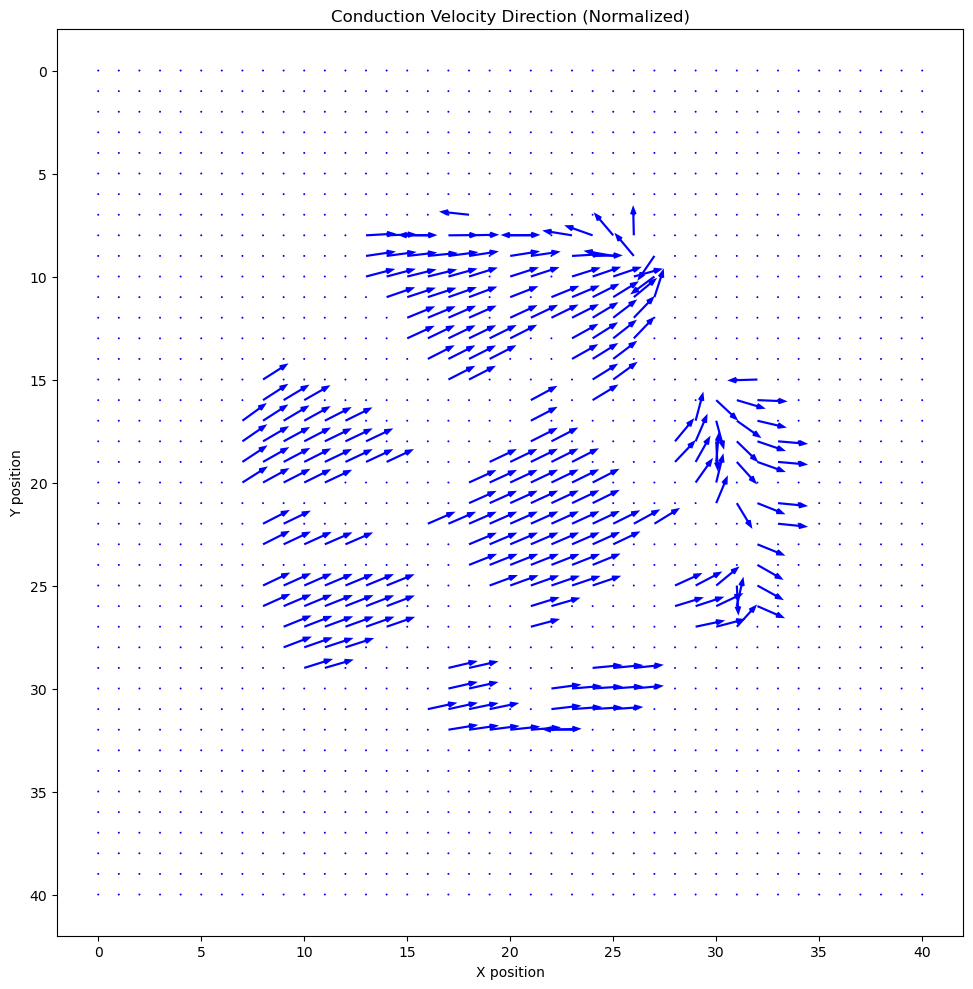

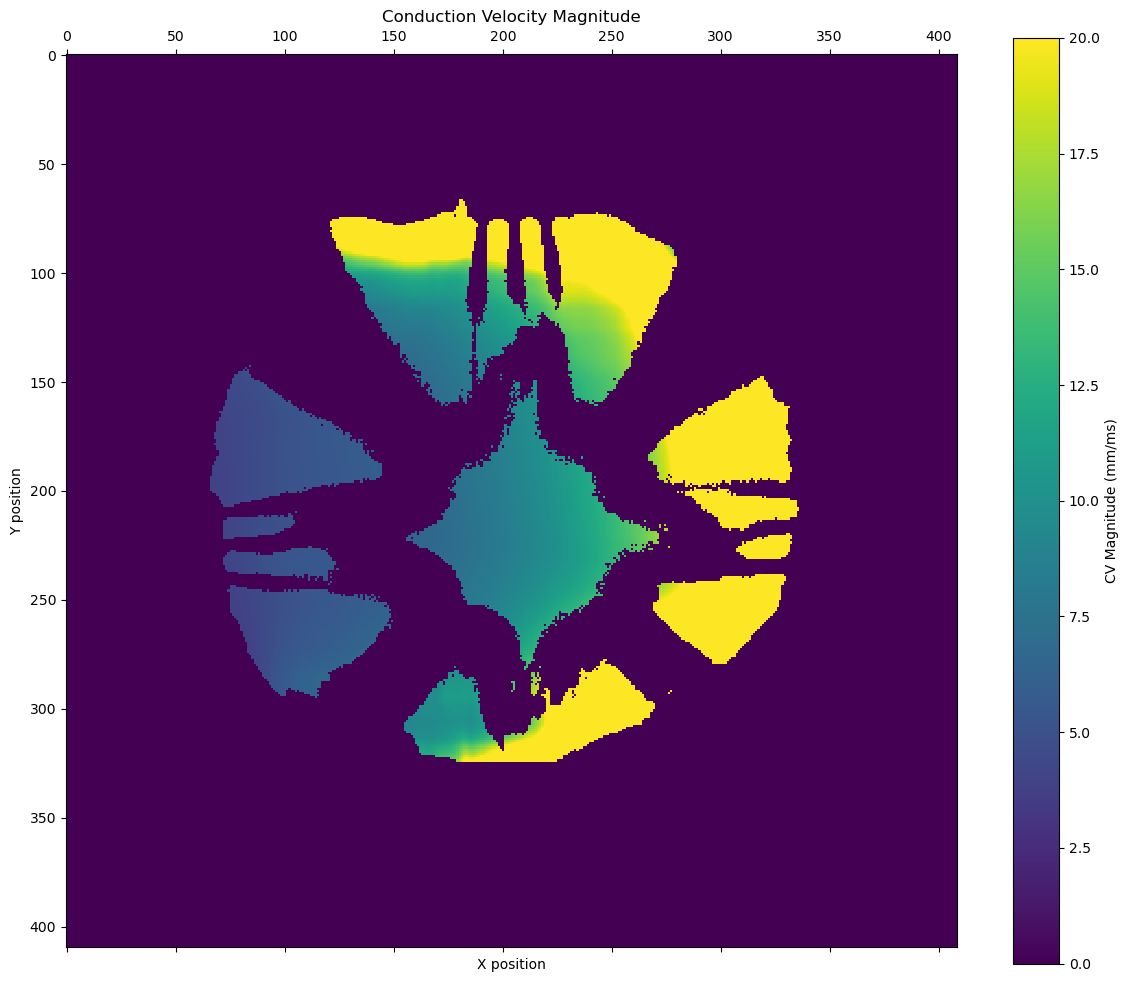

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Function to downsample the CV field
def downsample_cv(cv_x, cv_y, factor):
    return cv_x[::factor, ::factor], cv_y[::factor, ::factor]

# Downsample the CV field (adjust the factor as needed)
downsample_factor = 10
cv_x_down, cv_y_down = downsample_cv(-cv_x, cv_y, downsample_factor)

# Create a grid for the quiver plot
y, x = np.mgrid[0:cv_x_down.shape[0], 0:cv_x_down.shape[1]]

# Normalize the vectors to have unit length
magnitude = np.sqrt(cv_x_down**2 + cv_y_down**2)
cv_x_norm = np.where(magnitude != 0, cv_x_down / magnitude, 0)
cv_y_norm = np.where(magnitude != 0, cv_y_down / magnitude, 0)

# Create the quiver plot
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Conduction Velocity Direction (Normalized)')
quiver = ax.quiver(x, y, cv_x_norm, cv_y_norm, 
                   scale=30, headwidth=3, headlength=4, color='blue')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')

# Set aspect ratio to equal for square pixels
ax.set_aspect('equal')

# Invert y-axis to match matshow orientation
ax.invert_yaxis()

# Add a single arrow as a reference
ax.quiverkey(quiver, X=0.9, Y=1.05, U=1, label='Unit vector', labelpos='E')

plt.tight_layout()
plt.show()

# Plot of CV magnitude as a heatmap for comparison
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Conduction Velocity Magnitude')
im = ax.matshow(cv_magnitude, cmap='viridis', vmin=0, vmax=20)
plt.colorbar(im, label='CV Magnitude (mm/ms)')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')

plt.tight_layout()
plt.show()

In [12]:
magnitude

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])